<a href="https://colab.research.google.com/github/jamsun9907/Projects/blob/main/Video_game_data_analysis/Gamedata_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**
=====
기간 : 2024.09.11 ~ 2024.09.16 (6일간)
> 게임데이터로 비즈니스가치를 도출해보고자 본인을 게임회사의 데이터 분석가로 가정하고 진행한 비디오게임 분석 프로젝트
---------------------------------------
0. **문제정의**
- Key ask : 다음 분기에 어떤 장르의 게임을 설계해야 하는가?

1. **주요 분석 과제**
- 지역에 따라서 선호하는 게임 장르가 다른가?
- 연도별 게임의 트렌드가 존재하는가?
- 출고량이 높은 게임에 대한 분석 및 시각화

2. **사전 주요 가정**
* 데이터 분석 목표 : 다음분기(2017년도) 게임 기획을 위한 탐색
* 기획 시점 : 2016년 12월 말* <br>
* 회사 정보
    * 콘솔게임 개발사
    * 주요 매출은 RPG 게임 IP에서 창출**
    * 글로벌 시장에서도 어느정도 인지도 보유
    * 새로운 장르의 게임 개발 역량 보유
<br>
<br>

\* 원본 데이터의 시간 범위는 2017년까지 존재하나 17년도 데이터는 3개에 불과. 이를 제외하여 분석 목표의 다음 분기는 2017년도 1분기로 설정, 기획 시점은 2016년도 12월로 가정<br>
\** RPG게임을 좋아하는 개인적 선호에 따라 RPG게임 회사라고 가정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load pakages & Settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

#-------------------------------------------
pd.options.display.max_rows = 30

### Data Source
> 원본 데이터 : 캐글의 Video Game Sales<br>
https://www.kaggle.com/datasets/gregorut/videogamesales

In [ ]:
# Data acquisition

path = r'/content/drive/MyDrive/0.Data for analysis/Project/vgames2.csv'

raw = pd.read_csv(path, index_col='Unnamed: 0')
print(raw.shape)

(16598, 9)


In [ ]:
raw.sample(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
6774,Daito Giken Koushiki Pachi-Slot Simulator: 24 ...,PS2,2008.0,Misc,Paon,0,0,0.01,0
1165,Yumi's Odd Odyssey,3DS,2013.0,Platform,Agatsuma Entertainment,0,0,0.03,0
7638,In The Groove,PS2,2005.0,Misc,RedOctane,0.04,0.03,0,0.01
9068,Imagine: Babysitters,DS,2008.0,Simulation,Ubisoft,0.63,0.36,0,0.1
16556,Apache: Air Assault,PC,2010.0,NaN,Just Flight,0,0.03,0,0.01
2888,Hanagumi Taisen Columns,SAT,1997.0,Puzzle,Sega,0,0,0.12,0
10373,Maximum Capacity: Hotel Giant,PC,2002.0,Strategy,JoWood Productions,0,0.02,0,0
7022,Crash: Twinsanity,XB,2004.0,Platform,Vivendi Games,0.11,0.03,0,0.01
3536,Virtua Tennis 4: World Tour,PSV,2011.0,Sports,Sega,0.05,0.3,0.01,0.12
16189,Super Street Fighter II,GEN,1993.0,Fighting,Capcom,0,0,0.15,0


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


**Data Preparation**
====

### 1. Handdling Missing value
- Year   # 271
- Genre  # 50
- Publisher # 58 -> 우리의 분석에서 필요한가? 추후 필요하면 추가           

### 2. Duplicates
- name 중복되는 경우   
   
### 3. Inaccurate data

**Datatype 변경**
- Platform, Genre -> Categorical
- Year -> Int
- NA~other Sales -> float

**Outlier (이상치 조정)**
- Year 0~100 처리

In [ ]:
# 분석에 사용할 데이터
df = raw.copy()

# 이름에 따라 데이터 재 정렬
df = df.sort_values(by = 'Name', ascending = True).reset_index(drop = True)

## 1. Handdling Missing value

Genre : 제거   
Year : 일단 제거   
Publisher : 분석에 안쓸 것이므로 결측값은 'Unknown'으로 대채
* 둘 다 시간 되면 외부데이터를 통해 결측치를 채워 넣는다.

In [ ]:
# Missing value 확인
df.isna().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [ ]:
df[df['Genre'].isna() | df['Year'].isna()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
147,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,NaN,0,0,0.01,0
198,Action Man-Operation Extreme,PS,NaN,Action,NaN,0.05,0.03,0,0.01
214,Advance Wars: Days of Ruin,DS,NaN,Strategy,Nintendo,0.44,0.13,0,0.06
217,Adventure,2600,NaN,Adventure,Atari,1.21,0.08,0,0.01
250,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,Idea Factory,0,0,0.01,0
...,...,...,...,...,...,...,...,...,...
16405,Yu Yu Hakusho: Dark Tournament,PS2,NaN,Fighting,NaN,0.1,0.08,0,0.03
16412,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,NaN,Racing,Unknown,0,0,0.02,0
16498,Zero: Tsukihami no Kamen,Wii,NaN,Action,Nintendo,0,0,0.08,0
16568,eJay Clubworld,PS2,NaN,Misc,Empire Interactive,0.07,0.06,0,0.02


In [ ]:
# 결측치 처리
df_clean = df.dropna(subset = ['Genre','Year'])

# 확인
df_clean[df_clean['Genre'].isna() | df_clean['Year'].isna()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


In [ ]:
# Publisher 결측치 대채
# df[df['Publisher'].isna()]
df_clean = df_clean.replace(np.nan, 'Unknown')

# 확인
df_clean[df_clean['Publisher'].isna()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


## 2. Duplicates

In [ ]:
# duplicates 확인
print(df_clean.shape[0] - df_clean['Name'].nunique()) #중복값 4947개 -> 전처리 후 다시 확인, Handle 하기.

4947


In [ ]:
df_clean[df_clean.duplicated(subset = ['Name','Platform'], keep = False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7712,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.23,0,0.22
7716,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,0,0.01,0,0
9621,Need for Speed: Most Wanted,PC,2012.0,Racing,Electronic Arts,0,0.06,0,0.02
9622,Need for Speed: Most Wanted,PC,2005.0,Racing,Electronic Arts,20K,0.23,0,0.05
9624,Need for Speed: Most Wanted,X360,2005.0,Racing,Electronic Arts,1,0.17,0.02,0.1
9630,Need for Speed: Most Wanted,X360,2012.0,Racing,Electronic Arts,0.62,0.8,0.01,0.15


**중복값을 보면 겹친 두 값 중 주로 후자에 나온 값이 데이터를 더욱 많이 보존하고 있음. 따라서 keep = 'last'로 설정**

In [ ]:
# 진짜 중복값 (Name과 Platform 둘다 동일한 중복값)
df_duplicates = df_clean[df_clean.duplicated(subset = ['Name','Platform'], keep = 'last')]
print(f'# of duplicates : {df_duplicates.shape[0]}')

# 중복값 저장
df_duplicates

# of duplicates : 3


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7712,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.23,0,0.22
9621,Need for Speed: Most Wanted,PC,2012.0,Racing,Electronic Arts,0,0.06,0,0.02
9624,Need for Speed: Most Wanted,X360,2005.0,Racing,Electronic Arts,1,0.17,0.02,0.1


In [ ]:
# 중복값 처리
df_clean = df_clean.drop_duplicates(subset = ['Name','Platform'], keep = 'last')

# 최종 확인
df_clean[df_clean.duplicated(subset = ['Name','Platform'], keep = 'last')]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales


## 3. Inaccurate data

###**Data type transformataion**
* Year -> int
* Platform / Genre -> Category
* Sales -> float (Unit : Million)

In [ ]:
# Dtype 변경 - 이상치 탐색을 위해
# Year
df_clean['Year'] = df_clean['Year'].astype('int')

# Platform / Genre
#df_clean['Platform'] = df_clean['Platform'].astype('category')
df_clean['Genre'] = df_clean['Genre'].astype('category')

In [ ]:
# 이상한 sales 값 찾기
import re

def not_num(a):
  return bool(re.search('[A-z]', a))

error = df['NA_Sales'].apply(not_num)
df['NA_Sales'][error]

188      0.37M
233        60K
340      0.22M
483        90K
552      0.02M
         ...  
16340       0M
16383      60K
16454       0M
16464       0M
16554    0.14M
Name: NA_Sales, Length: 200, dtype: object

In [ ]:
# 문자 숫자 대채 함수 (단위: M)

def cleaner(col):

  temp_list = []

  for row in col:
    if bool(re.search('K', row)) == True:
      K = float(row.replace('K','')) * 0.001
      temp_list.append(K)

    elif bool(re.search('M', row)) == True:
      M = float(row.replace('M',''))
      temp_list.append(M)

    else : temp_list.append(float(row))

  return temp_list

In [ ]:
df1 = df_clean.copy()

# 함수 적용
for col in range(5,9):
  df1.iloc[:,col] = cleaner(df1.iloc[:,col])

# 확인
df1.info()
df1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16274 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16274 non-null  object  
 1   Platform     16274 non-null  object  
 2   Year         16274 non-null  int64   
 3   Genre        16274 non-null  category
 4   Publisher    16274 non-null  object  
 5   NA_Sales     16274 non-null  float64 
 6   EU_Sales     16274 non-null  float64 
 7   JP_Sales     16274 non-null  float64 
 8   Other_Sales  16274 non-null  float64 
dtypes: category(1), float64(4), int64(1), object(3)
memory usage: 1.1+ MB


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.10,0.12,0.03
1,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00
2,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03
3,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00
4,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00
...,...,...,...,...,...,...,...,...,...
16592,thinkSMART: Chess for Kids,DS,2011,Misc,Mentor Interactive,0.01,0.00,0.00,0.00
16593,uDraw Studio,Wii,2010,Misc,THQ,1.67,0.58,0.00,0.20
16594,uDraw Studio: Instant Artist,X360,2011,Misc,THQ,0.01,0.01,0.00,0.00
16595,uDraw Studio: Instant Artist,Wii,2011,Misc,THQ,0.08,0.09,0.00,0.02


### **Eliminating inaccurate data**
1. Year
* Year =< 0~22 은 앞에 20 이 전산오류로 빠진 것으로 추정
> 해당 값들에 2000을 더한다.
* Year > 0~22
> 해당 값들에 1900을 더한다.
* Year = 2020 데이터는 잘못된 데이터. 2020년에는 DS 단종되어서 게임이 나올 수 없다. 따라서 드랍한다.
2. Name
* ~~sales 지역 별로 동일한 게임 값이 나누어져 있다. 이를 정리하여 합친다.


In [ ]:
# Year 이상치 변경 함수
def year_normal(col):
  tmp = []

  for row in col:
    if row <= 22:
      tmp.append(row + 2000)
    elif  row <= 100 :
      tmp.append(row + 1900)
    else : tmp.append(row)

  return tmp

In [ ]:
# 이상치 변경
df1['Year'] = year_normal(df1['Year'])
df1.drop(index = df1.query('Year==2020').index,axis = 0, inplace = True) # 2020 드랍

# 확인
df1['Year'].sort_values()  # 시간 범위는 1980 ~ 2017

1526     1980
1466     1980
2891     1980
4758     1980
702      1980
         ... 
15124    2016
5473     2016
1544     2017
10307    2017
10306    2017
Name: Year, Length: 16273, dtype: int64

## Feature engineering
분석의 용이성을 위해 플랫폼에 대하여 묶어주는 컬럼을 하나 생성한다.

### 1) 총계 피쳐 생성

In [ ]:
# 1. Total feature
Total = df1.iloc[:,5:9].sum(axis = 1)
df1['Total'] = Total

In [ ]:
df1

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
0,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.10,0.12,0.03,0.40
1,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17
2,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23
3,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00,0.16
4,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17
...,...,...,...,...,...,...,...,...,...,...
16592,thinkSMART: Chess for Kids,DS,2011,Misc,Mentor Interactive,0.01,0.00,0.00,0.00,0.01
16593,uDraw Studio,Wii,2010,Misc,THQ,1.67,0.58,0.00,0.20,2.45
16594,uDraw Studio: Instant Artist,X360,2011,Misc,THQ,0.01,0.01,0.00,0.00,0.02
16595,uDraw Studio: Instant Artist,Wii,2011,Misc,THQ,0.08,0.09,0.00,0.02,0.19


### 2) Platform 타입 피쳐 생성
게임 기기의 타입은 크게 portable, console, pc로 나눠볼 수 있다.
분석의 용이성을 위해 새로운 피쳐를 추가한다.

In [ ]:
# Console type 카테고리 추가
portable = ['PSV','PSP','3DS','DS','GBA','GB','WS']
console = ['PS4','PS3','PS2','PS','XOne','X360','XB','WiiU','Wii','GC','N64','SNES','SAT','2600','NES','DC','GEN','NG','3DO','TG16','PCFX','GG','SCD']
pc = ['PC']


df1['Type'] = df1['Platform']

# 각 value 값 변경
df1['Type'][df1['Type'].isin(console)] = 'Console'
df1['Type'][df1['Type'].isin(portable)] = 'Portable'
df1['Type'][df1['Type'].isin(pc)] = 'PC'

# 카테고리 데이터로 변경
df1['Type'].astype('category')

0         Console
1         Console
2         Console
3         Console
4         Console
           ...   
16592    Portable
16593     Console
16594     Console
16595     Console
16597    Portable
Name: Type, Length: 16273, dtype: category
Categories (3, object): ['Console', 'PC', 'Portable']

### 3) 필요없는 열 드랍
전치리 용이성을 위해 기존 Publisher,platform 열은 드랍한다.


In [ ]:
# Platform, Publiser 드랍
#df1.drop(['Platform'],axis = 1, inplace = True)

### 4) Column 순서 재정렬

In [ ]:
# 컬럼 순서 보기 좋게 변경
df1 = df1[['Name','Type', 'Genre', 'Year','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total','Platform','Publisher']]

df1.columns

Index(['Name', 'Type', 'Genre', 'Year', 'NA_Sales', 'EU_Sales', 'JP_Sales',
       'Other_Sales', 'Total', 'Platform', 'Publisher'],
      dtype='object')

In [ ]:
df1

,Name,Type,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total,Platform,Publisher
0,'98 Koshien,Console,Sports,1998,0.15,0.10,0.12,0.03,0.40,PS,Magical Company
1,.hack//G.U. Vol.1//Rebirth,Console,Role-Playing,2006,0.00,0.00,0.17,0.00,0.17,PS2,Namco Bandai Games
2,.hack//G.U. Vol.2//Reminisce,Console,Role-Playing,2006,0.11,0.09,0.00,0.03,0.23,PS2,Namco Bandai Games
3,.hack//G.U. Vol.2//Reminisce (jp sales),Console,Role-Playing,2006,0.00,0.00,0.16,0.00,0.16,PS2,Namco Bandai Games
4,.hack//G.U. Vol.3//Redemption,Console,Role-Playing,2007,0.00,0.00,0.17,0.00,0.17,PS2,Namco Bandai Games
...,...,...,...,...,...,...,...,...,...,...,...
16592,thinkSMART: Chess for Kids,Portable,Misc,2011,0.01,0.00,0.00,0.00,0.01,DS,Mentor Interactive
16593,uDraw Studio,Console,Misc,2010,1.67,0.58,0.00,0.20,2.45,Wii,THQ
16594,uDraw Studio: Instant Artist,Console,Misc,2011,0.01,0.01,0.00,0.00,0.02,X360,THQ
16595,uDraw Studio: Instant Artist,Console,Misc,2011,0.08,0.09,0.00,0.02,0.19,Wii,THQ


In [ ]:
# 컬럼이름 재정의
#df_str = df1.rename(columns = {'NA_Sales':'North_America', 'EU_Sales':'EU', 'JP_Sales':'JP','Other_Sales': 'Other'})

# Melt 로 sales 데이터 병합
#id = ['Name', 'Platform', 'Year', 'Genre', 'Publisher']
#value = ['North_America', 'EU', 'JP', 'Other']
#var = 'Region'
#val_name = 'Sales'

#df_str = pd.melt(df_str, id_vars = id, value_vars = value, var_name = var, value_name = val_name)

### 5) 이름 중복되는 데이터 처리

이름에 중복되는 데이터들의 경우, (~~sales US sales 등) 지역 별 데이터가 나누어진 것으로 join 한다.

In [ ]:
# 이름 중복값 찾기 함수 선언
def error_finder(df):
  #regex = re.compile('\(\D+\)')
  pattern = re.compile('sales')
  match2 = df['Name'].str.contains(pat = pattern)

  error = df['Name'][match2].sort_values()

  return error

In [ ]:
# 이상한 이름 각각 나누기
dupi = error_finder(df1).str.split(r"\(",expand = True)[0]
dupi.replace('\s+$', '', regex=True, inplace=True) #공백제거

mapi = error_finder(df1)

In [ ]:
# Name에서 괄호안에 sales 들어간 값 모두 제거
# problems = df1[df1['Name'].isin(dupi.unique()) | df1['Name'].isin(mapi)]
#problems.replace('\s\([A-z].+',"", regex = True)

df1 = df1.replace('\s\([A-z].+',"", regex = True).groupby(['Name','Type','Platform','Publisher']).agg({'Genre':'first','Year':min,'NA_Sales':sum,'EU_Sales':sum,'JP_Sales':sum,'Other_Sales':sum,'Total':sum}) # 총 레코드의 개수는 12770개

In [ ]:
df1

,,,,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Name,Type,Platform,Publisher,,,,,,,
'98 Koshien,Console,PS,Magical Company,Sports,1998,0.15,0.10,0.12,0.03,0.40
.hack//G.U. Vol.1//Rebirth,Console,PS2,Namco Bandai Games,Role-Playing,2006,0.00,0.00,0.17,0.00,0.17
.hack//G.U. Vol.2//Reminisce,Console,PS2,Namco Bandai Games,Role-Playing,2006,0.11,0.09,0.16,0.03,0.39
.hack//G.U. Vol.3//Redemption,Console,PS2,Namco Bandai Games,Role-Playing,2007,0.00,0.00,0.17,0.00,0.17
.hack//Infection Part 1,Console,PS2,Atari,Role-Playing,2002,0.49,0.38,0.26,0.13,1.26
...,...,...,...,...,...,...,...,...,...,...
thinkSMART: Chess for Kids,Portable,DS,Mentor Interactive,Misc,2011,0.01,0.00,0.00,0.00,0.01
uDraw Studio,Console,Wii,THQ,Misc,2010,1.67,0.58,0.00,0.20,2.45
uDraw Studio: Instant Artist,Console,Wii,THQ,Misc,2011,0.08,0.09,0.00,0.02,0.19


In [ ]:
# 멀티 인덱스 없애기
df1.reset_index(inplace = True)

## 힘들게 정리한 데이터 저장



In [ ]:
df1.to_csv('Games_cleaned.csv', index = False)
#df_str.to_csv('Games_structured.csv', index = False)

**EDA**
======
**확인할 것**
1. 기술통계량
2. 시각화   


## **역대 모든 범위**
분석 범위: 1980 - 2017
역대 모든 범위를 통해 총괄적인 흐름을 본다.

## **최근 3개년 추세**
2014~2016 기간의 게임이 최근의 트랜드를 반영한다.
따라서 다음 게임을 기획할 때 필요한 주요 분석 대상은 해당 기간으로 한다.
다만 역대 모든 범위를 먼저 기본적으로 분석한 후 위에서 데이터 범위를 제한하여 하위 분석이 돌아가도록 한다.

### 1. Descriptive statistics

In [ ]:
df = pd.read_csv('Games_cleaned.csv')

df = df.query('Year <2017 & Year >= 2014') # 3개년 추세 분석을 위한 데이터 제한

print(df.shape)
df.describe() # 북아메리카와 유럽에서의 판매량이 다수를 차지한다.

(1537, 11)


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,2014.845153,0.166851,0.162225,0.056337,0.050371,0.435784
std,0.760836,0.440823,0.453319,0.212547,0.148255,1.040720
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,0.030000
50%,2015.000000,0.020000,0.030000,0.010000,0.010000,0.100000
75%,2015.000000,0.130000,0.130000,0.050000,0.040000,0.370000
max,2016.000000,5.770000,6.060000,3.180000,2.310000,14.240000


In [ ]:
# 총 게임의 개수
df.Name.nunique()

867

In [ ]:
df.head()

,Name,Type,Platform,Publisher,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
35,12-Sai. Honto no Kimochi,Portable,3DS,Happinet,Adventure,2014,0.00,0.00,0.07,0.00,0.07
36,12-Sai. Koisuru Diary,Portable,3DS,Happinet,Adventure,2016,0.00,0.00,0.04,0.00,0.04
65,2014 FIFA World Cup Brazil,Console,PS3,Electronic Arts,Sports,2014,0.15,0.39,0.01,0.16,0.71
66,2014 FIFA World Cup Brazil,Console,X360,Electronic Arts,Sports,2014,0.14,0.28,0.00,0.04,0.46
77,3DS Classic Collection,Portable,3DS,Sega,Misc,2016,0.02,0.00,0.00,0.00,0.02


#### 시장 규모

Text(0.5, 1.0, 'Market Portion')

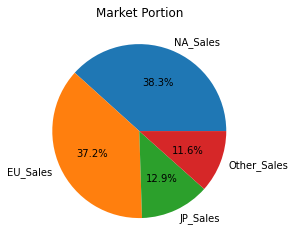

In [ ]:
# 시장 규모
region = df.loc[:,'NA_Sales':'Other_Sales'].sum()
total = df.Total.sum()

# Market Size
plt.pie(round(region/total*100, 1),labels= region.index, autopct='%.1f%%')
plt.title('Market Portion')

**Point!**   
시장 규모는 미국 > 유럽 > 일본 > 기타 지역 순이다.

데이터에 outlier가 다소 존재하여 대푯값은 이상치에 로버스트한 중앙값으로 설정한다.


#### 장르에 따른 평균 판매량

In [ ]:
df.groupby(by = 'Genre').mean().sort_values(by = 'Total', ascending = False).head(5)

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Genre,,,,,,
Shooter,2014.867257,0.610177,0.510973,0.038761,0.170000,1.329912
Sports,2014.890323,0.276452,0.275806,0.020000,0.090710,0.662968
Platform,2015.000000,0.185588,0.185588,0.078235,0.050588,0.500000
Fighting,2014.844828,0.208448,0.113793,0.107414,0.049310,0.478966
Role-Playing,2014.755981,0.135407,0.119856,0.134211,0.036699,0.426172


In [ ]:
df.groupby(by = 'Genre').sum().sort_values(by = 'Total', ascending = False).head(5)

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Genre,,,,,,
Action,1124303,66.43,70.73,27.85,22.10,187.11
Shooter,227680,68.95,57.74,4.38,19.21,150.28
Sports,312308,42.85,42.75,3.10,14.06,102.76
Role-Playing,421084,28.30,25.05,28.05,7.67,89.07
Misc,197447,14.46,12.67,5.27,4.14,36.54


**장르별 기술 통계량**
* 평균적으로는 Shooter, Sports, Fighting 장르가 높은 점유율을 기록했다.
* 반면, 누적 판매량은 Action, Shooter, Sports 장르가 상위 점유율을 보였다.

#### 지역 별 장르 점유율
> 점유율이므로 누적 판매량을 기준으로 집계한다.

In [ ]:
# 북아메리카에서 선호하는 장르
Total_sum = df.Total.sum()

df_genre_NA = df.groupby(by = 'Genre').sum().sort_values(by = 'NA_Sales', ascending = False)['NA_Sales']
# df_genre_NA = round(df_genre_NA/Total_sum*100,1)


In [ ]:
# 유럽에서 선호하는 장르
df_genre_EU = df.groupby(by = 'Genre').sum().sort_values(by = 'EU_Sales', ascending = False)['EU_Sales']
# df_genre_EU = round(df_genre_EU/Total_sum*100,1) # 유럽과 북미의 장르 선호도는 비슷하게 나타났다. (다만 가설 검증 필요)

In [ ]:
# 일본에서 선호하는 장르
df_genre_JP = df.groupby(by = 'Genre').sum().sort_values(by = 'JP_Sales', ascending = False)['JP_Sales']
#df_genre_JP = round(df_genre_JP/Total_sum*100,1) # 명확히 롤플레잉 게임이 우위를 점한다. 북미, 유럽에서 높은 점유율을 보이던 슈팅 게임은 일본에서는 통하지 않았다.

In [ ]:
# 기타 지역에서 선호하는 장르
df_genre_Ot = df.groupby(by = 'Genre').sum().sort_values(by = 'Other_Sales', ascending = False)['Other_Sales']
#df_genre_Ot = round(df_genre_Ot/Total_sum*100,1) # 기타 지역은 일본을 제외한 나머지 지역과 비슷한 장르 분포를 보인다.

In [ ]:
# 추후 가설 검증을 위해 저장
Genre_df = pd.concat([df_genre_NA,df_genre_EU, df_genre_JP,df_genre_Ot], axis = 1)
Genre_df

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Shooter,68.95,57.74,4.38,19.21
Action,66.43,70.73,27.85,22.10
Sports,42.85,42.75,3.10,14.06
Role-Playing,28.30,25.05,28.05,7.67
Misc,14.46,12.67,5.27,4.14
Fighting,12.09,6.60,6.23,2.86
Racing,8.16,13.58,1.75,2.81
Platform,6.31,6.31,2.66,1.72
Adventure,5.04,5.86,3.37,1.64


**Insight**
- 유럽과 북미의 장르 선호도는 비슷하게 나타났다. (다만 가설 검증 필요)
- 일본에서는 명확히 롤플레잉 게임이 우위를 점한다. 북미, 유럽에서 높은 점유율을 보이던 슈팅 게임은 일본에서는 통하지 않았다.
- 기타 지역은 일본을 제외한 나머지 지역과 비슷한 장르 분포를 보인다.
- Action 게임의 경우 지역 상관없이 항상 상위 3개 판매량을 보였다.
> 4개 집단의 차이 검정을 위해 카이제곱 분석이 필요할 것으로 보인다.

### 2. Visualization
1) 플랫폼 선호도
- 지역별
- 연도별

#### 지역 별 장르 선호도

(0.0, 80.0)

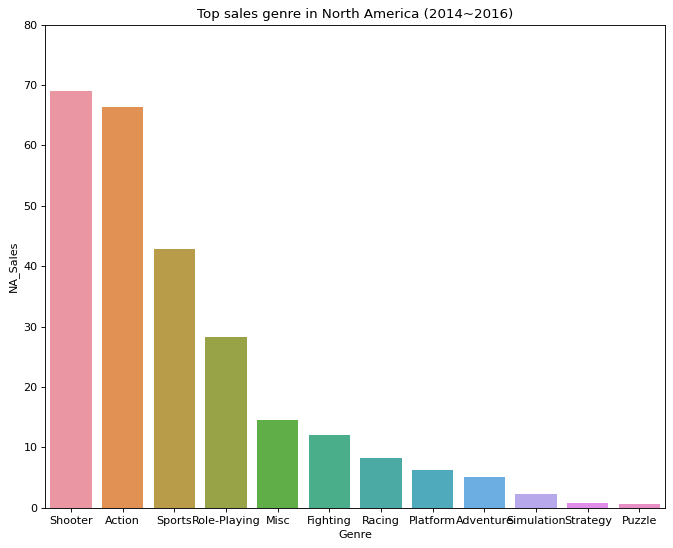

In [ ]:
plt.figure(figsize = (10, 8),dpi=80)

ax = sns.barplot(x=Genre_df.index, y="NA_Sales", data=Genre_df)

plt.title('Top sales genre in North America (2014~2016)')
plt.ylim(0,80)

(0.0, 80.0)

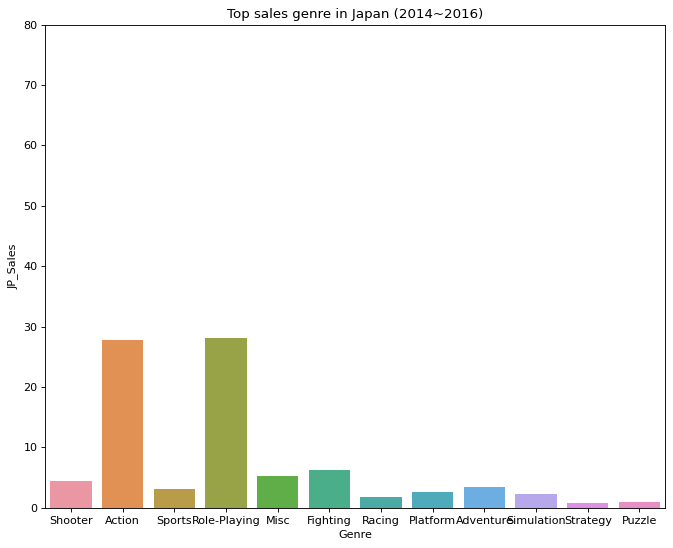

In [ ]:
plt.figure(figsize = (10, 8),dpi=80)

ax = sns.barplot(x=Genre_df.index, y="JP_Sales", data=Genre_df)

plt.title('Top sales genre in Japan (2014~2016)')
plt.ylim(0,80)

(0.0, 80.0)

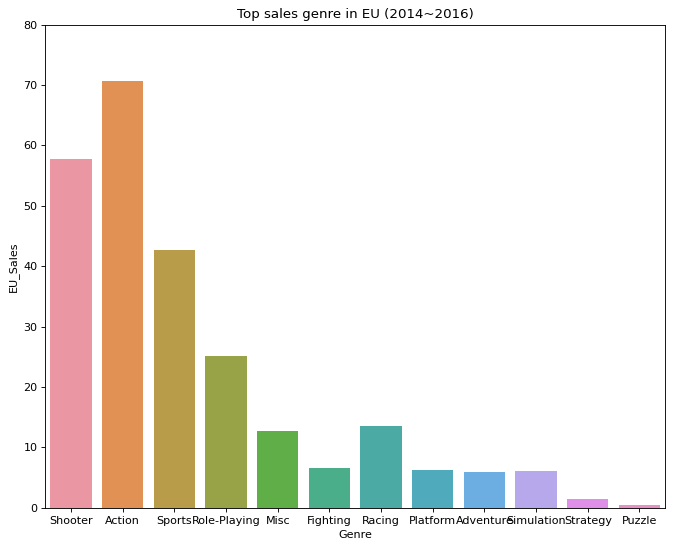

In [ ]:
plt.figure(figsize = (10, 8),dpi=80)

ax = sns.barplot(x=Genre_df.index, y="EU_Sales", data=Genre_df)

plt.title('Top sales genre in EU (2014~2016)')
plt.ylim(0,80)

(0.0, 80.0)

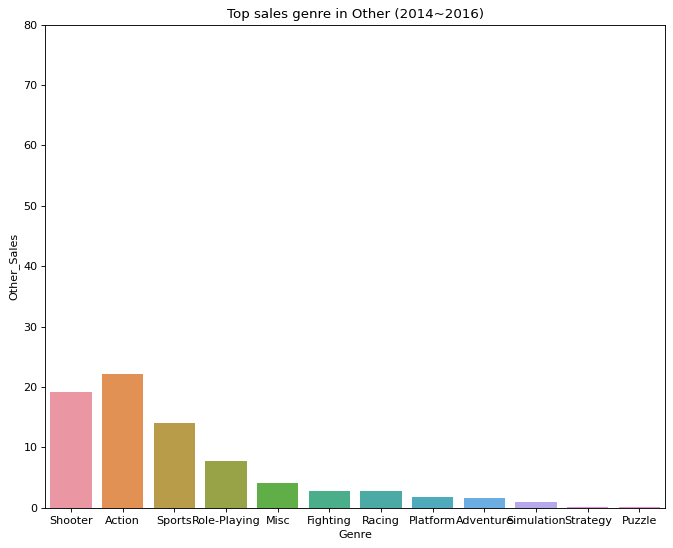

In [ ]:
plt.figure(figsize = (10, 8),dpi=80)

ax = sns.barplot(x=Genre_df.index, y="Other_Sales", data=Genre_df)

plt.title('Top sales genre in Other (2014~2016)')
plt.ylim(0,80)

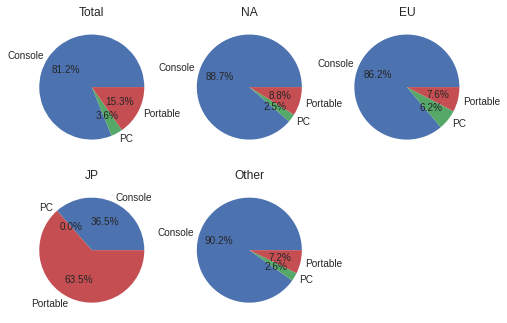

In [ ]:
# Platform Type 별 지역 점유율

plt.style.use('seaborn')

# Total
plt.subplot(2, 3, 1)
pie1 = df.groupby(by = 'Type')['Total'].sum()

plt.pie(x = pie1, labels = pie1.index, autopct='%.1f%%');
plt.title('Total')

# NA
plt.subplot(2, 3, 2)
pie2 = df.groupby(by = 'Type')['NA_Sales'].sum()

plt.pie(x = pie2, labels = pie2.index, autopct='%.1f%%');
plt.title('NA')

# EU
plt.subplot(2, 3, 3)
pie3 = df.groupby(by = 'Type')['EU_Sales'].sum()

plt.pie(x = pie3, labels = pie3.index, autopct='%.1f%%');
plt.title('EU')

# JP
plt.subplot(2, 3, 4)
pie4 = df.groupby(by = 'Type')['JP_Sales'].sum()

plt.pie(x = pie4, labels = pie4.index, autopct='%.1f%%');
plt.title('JP')

# Others
plt.subplot(2, 3, 5)
pie4 = df.groupby(by = 'Type')['Other_Sales'].sum()

plt.pie(x = pie4, labels = pie4.index, autopct='%.1f%%');
plt.title('Other')

plt.show()

💡 **Insight**
- 일본을 제외하고 콘솔의 점유율이 압도적으로 높다.
- 이는 닌텐도 DS와 같은 휴대용 게임 기기가 일본에서 특히 발달했다는 것을 알 수 있다.

-> 지역 별 콘솔 기기의 선호도에 차이가 나는지 여부에 대한 가설 검증이 가능하다. 뒤이어 계속

#### **플랫폼 선호도 추세**

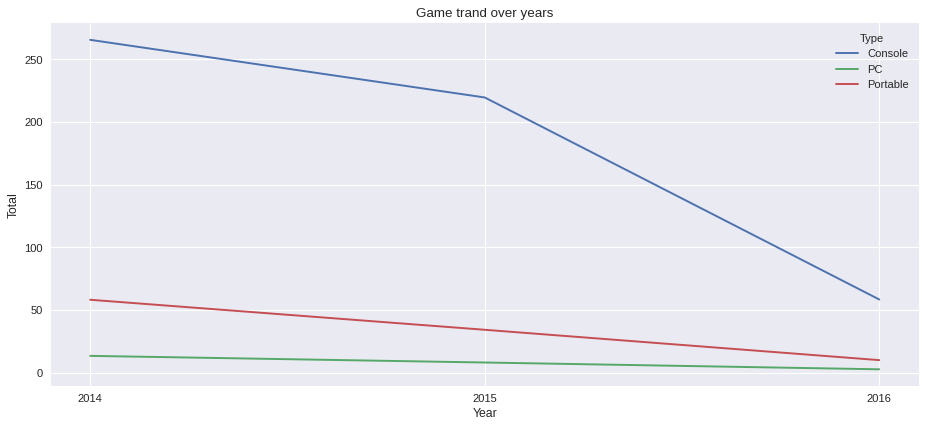

In [ ]:
# 연도별 플랫폼 점유율
plt.figure(figsize = (14, 6),dpi=80)

a = df.groupby(by = ['Type','Year']).sum()

sns.lineplot(data=a, x = 'Year', y = 'Total', hue = 'Type')
plt.title('Game trand over years')
plt.xticks(df['Year'].unique())
#plt.xlim(1990,2000)
#plt.ylim()
plt.show()

In [ ]:
df.query('Year == 2005').groupby(by = 'Type').sum()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Type,,,,,,


In [ ]:
df.query('Year == 2005').sort_values(by = 'Total', ascending = False).head(5)

,Name,Type,Platform,Publisher,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total


💡 **Insight**
- 연도 별로도, 콘솔이 지속적으로 우위를 점하고 있다.
- 그러나, 2005년의 경우 휴대용 게임 기기가 이를 바짝 추격했었는데, 이는 2005년 닌텐도의 역대 최고 인기를 보여주었던 타이틀이 발매되었기 때문인 것으로 추론된다.
  * 1위 닌텐독스 : 24M
  * 2위 마리오카트 : 23M
- 또한, 대체로 2005년~2010년 사이 비디오 게임 시장이 붐을 이루었지만 2010년도를 기점으로 기종 상관 없이 2017년까지 판매량이 지속적으로 감소하고있음을 알 수 있다.
  * 이는 2010년대 스마트폰의 발달로 점유율이 모바일 게임으로 넘어가고 있지 않나 조심스럽게 추측해본다.

#### 장르 별 추세

In [ ]:
# 지역별 장르 추세 그래프 그리는 함수 정의
def chart_maker(Region):
  plt.figure(figsize = (14, 6),dpi=80)

  a = df.groupby(by = ['Genre','Year'], as_index=False).sum().sort_values(by = Region, ascending = False)

  sns.lineplot(data=a, x = 'Year', y = Region, hue = 'Genre')
  plt.title(f'Popular {Region} genre over years')
  plt.xticks(df['Year'].unique())
  return plt.show()

In [ ]:
# df.groupby(by = ['Genre','Year'],as_index=False).sum().sort_values(by = 'Genre', ascending = True)

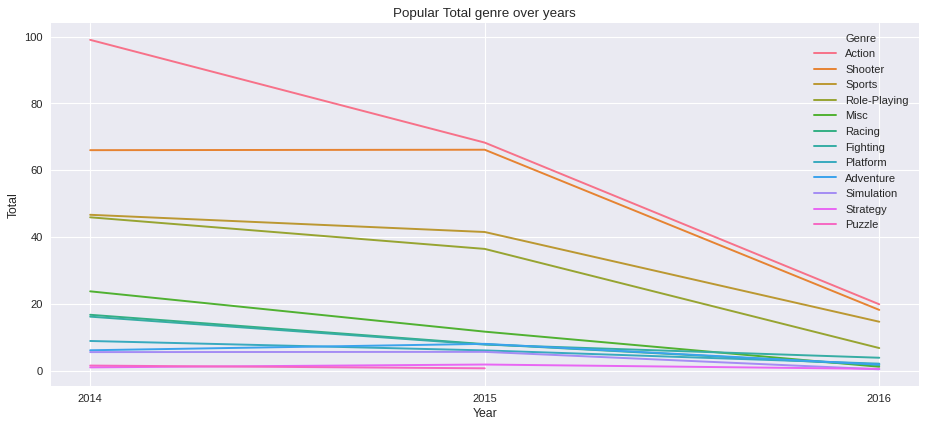

In [ ]:
chart_maker('Total') # 지역 값 컬럼 이름 넣으면 차트 만들어줌

#### Stacked bar chart - 장르별

In [ ]:
#df.set_index('Year').plot(kind='bar', stacked=True, color=['steelblue', 'red'])

In [ ]:
data = df.groupby(by = ['Genre','Year'], as_index=False).sum().sort_values(by = 'Total', ascending = False)[['Genre','Year','Total']]

In [ ]:
data.groupby(by = ['Genre']).sum().sort_values(by = 'Total', ascending = False).index

Index(['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc', 'Fighting',
       'Racing', 'Platform', 'Adventure', 'Simulation', 'Strategy', 'Puzzle'],
      dtype='object', name='Genre')

In [ ]:
# 차트를 그리려면 Year로 피봇을 해야함.
pivot = pd.pivot_table(data,
                       index = 'Year',  # 행 위치에 들어갈 열
                       columns = 'Genre', # 열 위치에 들어갈 열
                       values = 'Total', # 데이터로 사용할 열
                       aggfunc = sum)    # 데이터 집계함수
df_pivot = pivot.fillna(0)

In [ ]:
df_pivot

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
2014,99.01,6.09,16.15,23.73,8.87,1.51,16.71,45.89,65.99,5.54,46.64,0.97
2015,68.25,8.01,7.78,11.66,6.05,0.69,7.92,36.43,66.12,5.61,41.49,1.82
2016,19.85,1.81,3.85,1.15,2.08,0.00,1.67,6.75,18.17,0.39,14.63,0.52


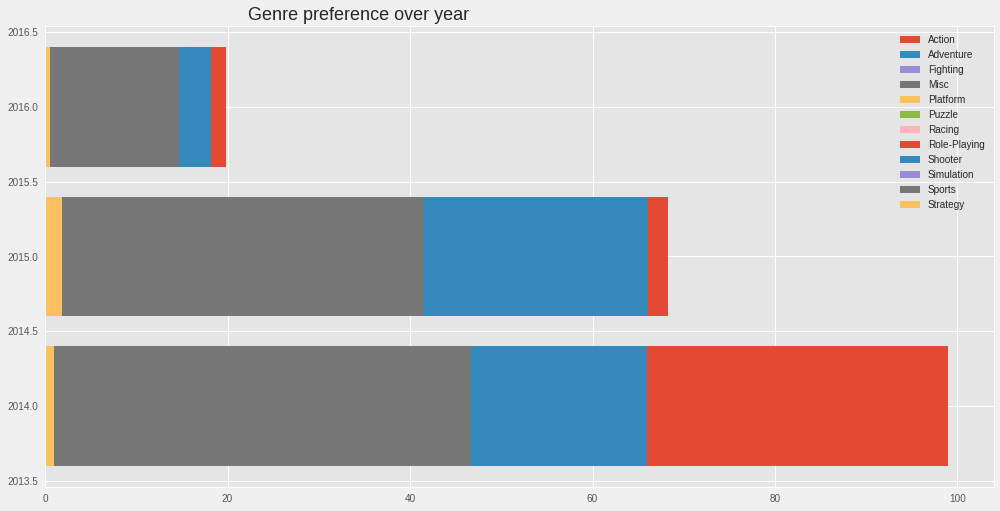

In [ ]:
# Plot stacked bar chart
import matplotlib as mpl
plt.style.use('ggplot') # 그래프 스타일

# Variables
index = pivot.index
values = [pivot.iloc[:,i] for i in range(pivot.shape[1])]
plot_title = 'Genre preference over year'
title_size = 18
subtitle = 'ing'
x_label = 'Year'
labels = pivot.columns

# Create subplots and set a colormap
fig, ax = plt.subplots(figsize = (14,8), facecolor=(.94, .94, .94)) # 그래프 크기
mpl.pyplot.plasma() # set colormap

for i in range(pivot.shape[1]):
  ax.barh(index, values[i], label = labels[i]) # 가로 바 차트

plt.tight_layout() #subplot fit 하기


#set title, fontsize, position
title = plt.title(plot_title, fontsize=title_size)
title.set_position([.33, 1])
plt.subplots_adjust(top=0.9, bottom=0.1)

# color
ax.grid(zorder=0)

# def gradientbars(bars):
#     grad = np.atleast_2d(np.linspace(0,1,256))
#     ax = bars[0].axes
#     lim = ax.get_xlim()+ax.get_ylim()
#     for bar in bars:
#         bar.set_zorder(1)
#         bar.set_facecolor('none')
#         x,y = bar.get_xy()
#         w, h = bar.get_width(), bar.get_height()
#         ax.imshow(grad, extent=[x+w, x, y, y+h], aspect='auto', zorder=1)
#     ax.axis(lim)

# gradientbars(bar)

ax.legend()

plt.show()

### Inference statistics
**두 카테고리 변수이므로 카이제곱 검정을 사용한다**
 - 지역별 장르 선호도 차이는 통계적으로 유의한가?      
 - 지역별 플랫폼 선호도 차이는 통계적으로 유의한가?   


### 1) 지역에 따른 선호하는 게임장르는 다른가?
- 카이제곱 검정
- 귀무가설: 지역에 따른 선호하는 게임장르는 차이가 없다.
- 대립가설: 지역에 따른 선호하는 게임장르는 차이가 있다.

[독립성 검정]    
- 귀무가설: 지역의 종류는 장르 별 판매량과 관계가 없다.(독립이다)   
- 대립가설 : 지역의 종류는 장르 별 판매량과 관계가 있다.(독립이 아니다)



In [ ]:
# 카이제곱 검정을 통한 가설검정
from scipy.stats import chi2_contingency

chi = chi2_contingency(Genre_df, correction = True)
print(f'X^2 statistics : {round(chi[0],2)}\np-value : {round(chi[1],4)}')

X^2 statistics : 63.52
p-value : 0.0011


**유의확률이 0.000 이므로 유의수준 0.05에서 지역 판매량과 장르 간에는 통계적으로 유의미한 관련성이 있는 것으로 나타났다.**

In [ ]:
# 그럼 미주와 유럽은?
chi = chi2_contingency(Genre_df.iloc[:,0:2], correction = True)
print(f'X^2 statistics : {round(chi[0],2)}\np-value : {round(chi[1],4)}') # 미주와 유럽은 장르에 따른 지역 판매량에 차이가 없음

X^2 statistics : 6.22
p-value : 0.8585


In [ ]:
Genre_df.loc[:,['NA_Sales','JP_Sales']]

,NA_Sales,JP_Sales
Genre,,
Shooter,68.95,4.38
Action,66.43,27.85
Sports,42.85,3.10
Role-Playing,28.30,28.05
Misc,14.46,5.27
Fighting,12.09,6.23
Racing,8.16,1.75
Platform,6.31,2.66
Adventure,5.04,3.37


In [ ]:
# 미주 X 일본
chi = chi2_contingency(Genre_df.loc[:,['NA_Sales','JP_Sales']], correction = False)
chi[:-1]
exp = pd.DataFrame(chi[3])
chi[:-1]

(46.48924799179154, 2.6491290311494604e-06, 11)

In [ ]:
# 의심되어서 직접 구해봄
obs = Genre_df.loc[:,['NA_Sales','JP_Sales']]
x_2 = []

for i in range(len(obs)):
  tmp = (obs.iloc[i,0] - exp.iloc[i,0])**2 / exp.iloc[i,0]
  x_2.append(tmp)
  tmp = (obs.iloc[i,1] - exp.iloc[i,1])**2 / exp.iloc[i,1]
  x_2.append(tmp)

print('X:',sum(x_2))

X: 46.48924799179152


### 2) 지역에 따른 선호하는 게임플랫폼은 다른가?   
[독립성 검정]   
귀무가설: 지역의 종류는 Type 별 판매량과 관계가 없다.(독립이다)   
대립가설 : 지역의 종류는 Type 별 판매량과 관계가 있다.(독립이 아니다)

In [ ]:
df_type = df.groupby(by = 'Type').sum().loc[:,['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_type

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Type,,,,
Console,227.37,214.84,31.60,69.81
PC,6.44,15.49,0.00,2.03
Portable,22.64,19.01,54.99,5.58


In [ ]:
# 카이제곱 검정을 통한 가설검정

chi = chi2_contingency(df_type, correction = True)
chi#전체 지역 간에는 차이가 없다고 나타남.
print(f'X^2 statistics : {round(chi[0],2)}\np-value : {round(chi[1],9)}')

X^2 statistics : 185.39
p-value : 0.0


유의확률이 0.0 이므로 유의수준 0.05에서 지역 판매량과 플랫폼 간에는 통계적으로 유의미한 관련성이 있는 것으로 나타났다.

In [ ]:
df_Platform = df.groupby(by = 'Platform').sum().loc[:,['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_Platform

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Platform,,,,
3DS,18.68,13.95,41.06,2.95
DS,0.02,0.00,0.00,0.00
PC,6.44,15.49,0.00,2.03
PS3,21.28,28.80,11.00,10.62
PS4,85.71,111.95,13.08,40.25
PSP,0.00,0.00,0.36,0.00
PSV,3.94,5.06,13.57,2.63
Wii,2.39,3.12,0.00,0.48
WiiU,19.04,12.38,7.12,3.65


In [ ]:
# 카이제곱 검정을 통한 가설검정

chi = chi2_contingency(df_type, correction = True)
chi[:-1] #전체 지역 간에는 차이가 없다고 나타남.

(185.39289141667234, 2.426111973288411e-37, 6)

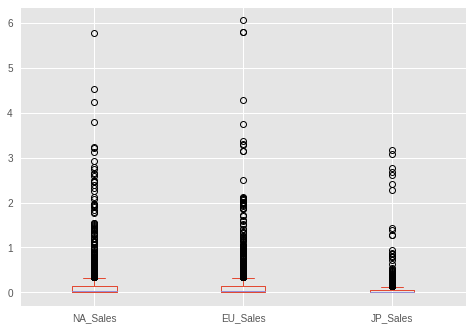

In [ ]:
# 박스플롯 그려보자.
ax = df.iloc[:,6:9].plot.box()
ax; # 이렇게 보아서는 차이를 모르겠다....

근 3년간(2014-2016) 출고량 상위 10개 게임에 대한 분석
======


### 2014-2016년 기간동안 전 지역에서 최고 판매량을 보여준 게임
* 주로 콘솔 게임
* 그 중 PS4, 3DS 플랫폼
* 슈팅, 엑션, 롤 플레잉 장르라는 공통점이 있다.

In [ ]:
df.query('Year >=2014').sort_values(by = 'Total', ascending = False).head(10).reset_index(drop = True)

,Name,Type,Platform,Publisher,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
0,Call of Duty: Black Ops 3,Console,PS4,Activision,Shooter,2015,5.77,5.81,0.35,2.31,14.24
1,Grand Theft Auto V,Console,PS4,Take-Two Interactive,Action,2014,3.80,5.81,0.36,2.02,11.99
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,Portable,3DS,Nintendo,Role-Playing,2014,4.23,3.37,3.08,0.65,11.33
3,FIFA 16,Console,PS4,Electronic Arts,Sports,2015,1.11,6.06,0.06,1.26,8.49
4,Star Wars Battlefront (2015),Console,PS4,Electronic Arts,Shooter,2015,2.93,3.29,0.22,1.23,7.67
5,Call of Duty: Advanced Warfare,Console,PS4,Activision,Shooter,2014,2.80,3.30,0.14,1.37,7.61
6,Super Smash Bros. for Wii U and 3DS,Portable,3DS,Nintendo,Fighting,2014,3.24,1.35,2.42,0.43,7.44
7,Call of Duty: Black Ops 3,Console,XOne,Activision,Shooter,2015,4.52,2.09,0.01,0.67,7.29
8,Fallout 4,Console,PS4,Bethesda Softworks,Role-Playing,2015,2.47,3.15,0.24,1.10,6.96
9,Mario Kart 8,Console,WiiU,Nintendo,Racing,2014,3.13,2.07,1.27,0.49,6.96


### 2016년 단일 년도 가장 많은 판매량을 보인 10가지 게임
2016년으로 한정할 경우 휴대용 게임기의 시대는 가고 **콘솔게임이 우세**했음을 알 수 있음
* 그 중 특히 PS4가 높은 판매량을 보여, 플랫폼 트랜드는 PS4임을 알 수 있음
* 장르의 경우 "Far cry, No man’s Sky"는 사실상 슈팅게임인 점을 감안한다면, **2016년도 장르 트랜드는 슈팅게임**이었다는 것을 시사

In [ ]:
df.query('Year >=2016').sort_values(by = 'Total', ascending = False).head(10).reset_index(drop = True)

,Name,Type,Platform,Publisher,Genre,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
0,FIFA 17,Console,PS4,Electronic Arts,Sports,2016,0.28,3.75,0.06,0.69,4.78
1,Uncharted 4: A Thief's End,Console,PS4,Sony Computer Entertainment,Shooter,2016,1.30,2.07,0.18,0.65,4.20
2,Tom Clancy's The Division,Console,PS4,Ubisoft,Shooter,2016,1.28,1.61,0.15,0.57,3.61
3,Far Cry: Primal,Console,PS4,Ubisoft,Action,2016,0.59,1.16,0.06,0.33,2.14
4,Tom Clancy's The Division,Console,XOne,Ubisoft,Shooter,2016,1.20,0.62,0.00,0.18,2.00
5,Overwatch,Console,PS4,Activision,Shooter,2016,0.64,0.68,0.14,0.26,1.72
6,No Man's Sky,Console,PS4,Hello Games,Action,2016,0.58,0.74,0.02,0.26,1.60
7,Dark Souls III,Console,PS4,Namco Bandai Games,Role-Playing,2016,0.58,0.44,0.33,0.21,1.56
8,FIFA 17,Console,XOne,Electronic Arts,Sports,2016,0.17,1.26,0.00,0.10,1.53
9,Doom (2016),Console,PS4,Bethesda Softworks,Shooter,2016,0.49,0.66,0.02,0.22,1.39


**Conclusion**
====
### **1. Summary**
1) 지역에 따른 장르 및 플랫폼 선호도
<br>
Genre :
* 전체 지역에서 Action, Shooter(슈팅게임) 게임이 선호(일본 제외)
* 일본은 RPG
<br>

Platform :
* 전체 지역에서 PC보다는 콘솔게임이 우세
* 일본은 특히 Nintendo

2) 연도별 (2014~2016) 게임 트랜드
<br>
* 2014~2016 각 년도에서 **액션 > 슈팅 > 스포츠** 순으로 순위 변동 없음
* 다만 2016년은 **슈팅게임** 장르가 Top sales에 주로 분포

----

### **2. Action Plan**
* 이상의 분석결과에 기반하여, 다음 분기 게임은 Action, Shooter 장르를 결합한 게임 기획을 제안하며, PS4 플랫폼 개발을 우선할 것을 제안.
* 또는, 일본 지역을 타게팅하여 기존 RPG 게임 IP를 활용하여 액션성을 가미한 확장팩 시리즈 개발